In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install flwr-datasets

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vu9mm1dm
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vu9mm1dm
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=8b437f76fe35b8166ef0c4f9e5012407b96b4430f0f5aea905f5b5579ce3367c
  Stored in directory: /tmp/pip-ephem-wheel-cache-qrvcp8i6/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 20.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing inst

In [ ]:
import torch
import random
import torchvision
import numpy as np
from PIL import Image
import os
import requests
from io import BytesIO
from datasets import load_dataset
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import clip
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from tqdm import tqdm
import seaborn as sns

In [ ]:
print("Loading PACS dataset from Flower Datasets...")
fds = FederatedDataset(
    dataset="flwrlabs/pacs",
    partitioners={"train": IidPartitioner(num_partitions=10)}
)


partition = fds.load_partition(partition_id=0)


pacs_data = partition

print(f"PACS dataset loaded with {len(pacs_data)} samples")
print(f"Columns: {list(pacs_data.features.keys())}")

Loading PACS dataset from Flower Datasets...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9991 [00:00<?, ? examples/s]

PACS dataset loaded with 1000 samples
Columns: ['image', 'domain', 'label']


In [ ]:
#Checking for device code

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

In [ ]:
#Setting of Models for comparison

base_model, base_preprocess = clip.load("RN50", device=device)
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 244M/244M [00:04<00:00, 58.2MiB/s]
100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 48.5MiB/s]


In [ ]:
class PACSHFDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        row = self.dataset[idx]
        img = row["image"].convert("RGB")
        label = row["label"]
        if self.transform:
            img = self.transform(img)
        return img, label


In [ ]:
pacs_domains = ['photo', 'art_painting', 'cartoon', 'sketch']

In [ ]:
#Dataloader set-ups for relevant models

BATCH_SIZE = 32

dataset_rn50 = CIFAR10(root='./data', train=False, download=True,
                      transform=base_preprocess)

dataset_vit32 = CIFAR10(root='./data', train=False, download=True,
                     transform=preprocess)

test_rn50loader = DataLoader(dataset_rn50, batch_size=BATCH_SIZE, shuffle=True)
test_vit32loader = DataLoader(dataset_vit32, batch_size=BATCH_SIZE, shuffle=True)

pacs_datasets_vit = {
    domain: PACSHFDataset(pacs_data.filter(lambda x: x["domain"] == domain), transform=preprocess)
    for domain in pacs_domains
}

pacs_datasets_rn50 = {
    domain: PACSHFDataset(pacs_data.filter(lambda x: x["domain"] == domain), transform=base_preprocess)
    for domain in pacs_domains
}

# Dataloaders
pacs_loaders_vit = {
    domain: DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)
    for domain, ds in pacs_datasets_vit.items()
}

pacs_loaders_rn50 = {
    domain: DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)
    for domain, ds in pacs_datasets_rn50.items()
}


100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]


Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
#Similarity Function for Image and Text
def similarity(image_features, text_features):
    similarity2 = (image_features @ text_features.T)
    probs = similarity2.softmax(dim=-1)
    predictions = similarity2.argmax(dim=1)
    return probs, predictions


#Evaluate Model Function
def evaluate(model, text_type, test_loader):
    text_features = model.encode_text(clip.tokenize(text_type).to(device))
    batch_accuracies = []
    model.eval()
    with torch.no_grad():
      for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            image_features = model.encode_image(images)
            probs, predictions = similarity(image_features, text_features)
            batch_acc = (predictions == labels).float().mean().item()
            batch_accuracies.append(batch_acc)
            print(f"Accuracy of Batch: {batch_acc}")
    final_accuracy = np.mean(batch_accuracies)
    return final_accuracy


In [ ]:
#Zero-Shot Preparation

CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
PAC_CLASSES = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

prompt_CIFAR10 = [f"a photo of a {c}" for c in CIFAR10_CLASSES]
prompt_PAC_image = [f"a photo of a {c}" for c in PAC_CLASSES]
prompt_PAC_art = [f"a painting of a {c}" for c in PAC_CLASSES]
prompt_PAC_cartoon = [f"a cartoon of a {c}" for c in PAC_CLASSES]
prompt_PAC_sketch = [f"a sketch of a {c}" for c in PAC_CLASSES]

In [ ]:
#ResNet50 vs CLIP on CIFAR10 with names only

rn50_cifar10_acc = evaluate(base_model, CIFAR10_CLASSES, test_rn50loader)
print(f"ResNet50 on CIFAR10 with prompts: {rn50_cifar10_acc}")
vit32_cifar10_acc = evaluate(model, CIFAR10_CLASSES, test_vit32loader)
print(f"ViT-B/32 on CIFAR10 with prompts: {vit32_cifar10_acc}")

Accuracy of Batch: 0.59375
Accuracy of Batch: 0.53125
Accuracy of Batch: 0.53125
Accuracy of Batch: 0.5
Accuracy of Batch: 0.65625
Accuracy of Batch: 0.6875
Accuracy of Batch: 0.625
Accuracy of Batch: 0.375
Accuracy of Batch: 0.625
Accuracy of Batch: 0.59375
Accuracy of Batch: 0.5625
Accuracy of Batch: 0.59375
Accuracy of Batch: 0.40625
Accuracy of Batch: 0.65625
Accuracy of Batch: 0.625
Accuracy of Batch: 0.5625
Accuracy of Batch: 0.59375
Accuracy of Batch: 0.5625
Accuracy of Batch: 0.53125
Accuracy of Batch: 0.625
Accuracy of Batch: 0.625
Accuracy of Batch: 0.8125
Accuracy of Batch: 0.6875
Accuracy of Batch: 0.75
Accuracy of Batch: 0.6875
Accuracy of Batch: 0.65625
Accuracy of Batch: 0.4375
Accuracy of Batch: 0.5625
Accuracy of Batch: 0.625
Accuracy of Batch: 0.65625
Accuracy of Batch: 0.4375
Accuracy of Batch: 0.5625
Accuracy of Batch: 0.5625
Accuracy of Batch: 0.53125
Accuracy of Batch: 0.5625
Accuracy of Batch: 0.5625
Accuracy of Batch: 0.59375
Accuracy of Batch: 0.5
Accuracy of B

In [ ]:
#ResNet50 vs CLIP on CIFAR10 with prompts

rn50_cifar10_acc = evaluate(base_model, prompt_CIFAR10, test_rn50loader)
print(f"ResNet50 on CIFAR10 with prompts: {rn50_cifar10_acc}")
vit32_cifar10_acc = evaluate(model, prompt_CIFAR10, test_vit32loader)
print(f"ViT-B/32 on CIFAR10 with prompts: {vit32_cifar10_acc}")

Accuracy of Batch: 0.65625
Accuracy of Batch: 0.625
Accuracy of Batch: 0.625
Accuracy of Batch: 0.625
Accuracy of Batch: 0.84375
Accuracy of Batch: 0.6875
Accuracy of Batch: 0.625
Accuracy of Batch: 0.625
Accuracy of Batch: 0.5
Accuracy of Batch: 0.6875
Accuracy of Batch: 0.5
Accuracy of Batch: 0.625
Accuracy of Batch: 0.65625
Accuracy of Batch: 0.625
Accuracy of Batch: 0.5625
Accuracy of Batch: 0.6875
Accuracy of Batch: 0.5625
Accuracy of Batch: 0.6875
Accuracy of Batch: 0.53125
Accuracy of Batch: 0.6875
Accuracy of Batch: 0.6875
Accuracy of Batch: 0.71875
Accuracy of Batch: 0.5
Accuracy of Batch: 0.59375
Accuracy of Batch: 0.59375
Accuracy of Batch: 0.5625
Accuracy of Batch: 0.71875
Accuracy of Batch: 0.53125
Accuracy of Batch: 0.625
Accuracy of Batch: 0.59375
Accuracy of Batch: 0.65625
Accuracy of Batch: 0.71875
Accuracy of Batch: 0.625
Accuracy of Batch: 0.71875
Accuracy of Batch: 0.53125
Accuracy of Batch: 0.84375
Accuracy of Batch: 0.65625
Accuracy of Batch: 0.53125
Accuracy of B

In [ ]:
#CLIP Performance on PAC Dataset

pacs_vit32_accuracies = {}
pacs_vit32_accuracies['art_painting'] = evaluate(model, prompt_PAC_art, pacs_loaders_vit['art_painting'])
pacs_vit32_accuracies['cartoon'] = evaluate(model, prompt_PAC_cartoon, pacs_loaders_vit['cartoon'])
pacs_vit32_accuracies['photo'] = evaluate(model, prompt_PAC_image, pacs_loaders_vit['photo'])
pacs_vit32_accuracies['sketch'] = evaluate(model, prompt_PAC_sketch, pacs_loaders_vit['sketch'])

for domain, accuracy in pacs_vit32_accuracies.items():
    print(f"ViT-B/32 on PACS {domain}: {accuracy}")

Accuracy of Batch: 0.875
Accuracy of Batch: 0.90625
Accuracy of Batch: 0.96875
Accuracy of Batch: 0.96875
Accuracy of Batch: 0.90625
Accuracy of Batch: 0.9375
Accuracy of Batch: 0.9523809552192688
Accuracy of Batch: 0.96875
Accuracy of Batch: 1.0
Accuracy of Batch: 0.96875
Accuracy of Batch: 1.0
Accuracy of Batch: 1.0
Accuracy of Batch: 1.0
Accuracy of Batch: 0.96875
Accuracy of Batch: 1.0
Accuracy of Batch: 1.0
Accuracy of Batch: 0.90625
Accuracy of Batch: 1.0
Accuracy of Batch: 1.0
Accuracy of Batch: 1.0
Accuracy of Batch: 1.0
Accuracy of Batch: 0.6875
Accuracy of Batch: 0.78125
Accuracy of Batch: 0.78125
Accuracy of Batch: 0.8125
Accuracy of Batch: 0.71875
Accuracy of Batch: 0.6875
Accuracy of Batch: 0.8125
Accuracy of Batch: 0.65625
Accuracy of Batch: 0.84375
Accuracy of Batch: 0.71875
Accuracy of Batch: 0.78125
Accuracy of Batch: 0.6538462042808533
ViT-B/32 on PACS art_painting: 0.9306972793170384
ViT-B/32 on PACS cartoon: 0.98828125
ViT-B/32 on PACS photo: 0.984375
ViT-B/32 on PA

In [ ]:
#Retrieval Test Dataset Preparation

original_images = []
for domain in pacs_domains:
    dataset = pacs_datasets_vit[domain]
    for i in range(5):
        j=random.randint(0, len(dataset)-1)
        raw_img = dataset.dataset[j]["image"]
        original_images.append(raw_img)

text_queries = [
        "a photo of a dog",
        "a painting of a horse",
        "a photo of a person",
        "a cartoon of a dog",
        "a sketch of a guitar",
        "a red automobile",
        "a flying airplane",
        "a elephant running in wild",
        "a wild animal in nature"
    ]

In [ ]:
# Image-Text Retrieval Implementation
def image_text_retrieval(model, preprocess, images, text_queries):
    image_embeddings = []

    for img in images:
        processed_img = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
            img_embed = model.encode_image(processed_img)
        image_embeddings.append(img_embed)

    image_embeddings = torch.cat(image_embeddings, dim=0)

    text_tokens = clip.tokenize(text_queries).to(device)
    with torch.no_grad():
        text_embeddings = model.encode_text(text_tokens)

    image_embeddings = image_embeddings / image_embeddings.norm(dim=1, keepdim=True)
    text_embeddings = text_embeddings / text_embeddings.norm(dim=1, keepdim=True)

    similarity = image_embeddings @ text_embeddings.T

    return similarity, images

def visualize_retrieval_results(similarity, original_images, text_queries, top_k=3):
    print("Text to Image Retrieval Visualisation")

    fig, axes = plt.subplots(len(text_queries), top_k + 1, figsize=(15, 3 * len(text_queries)))
    if len(text_queries) == 1:
        axes = axes.reshape(1, -1)

    for i, query in enumerate(text_queries):
        query_similarities = similarity[:, i]
        topk_indices = query_similarities.topk(top_k).indices.cpu().numpy()

        axes[i, 0].text(0.5, 0.5, f'Query:\n"{query}"',
                       ha='center', va='center', fontsize=12, wrap=True)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Text Query', fontweight='bold')

        for j, idx in enumerate(topk_indices):
            axes[i, j+1].imshow(original_images[idx])
            axes[i, j+1].set_title(f'Rank {j+1}\nSim: {similarity[idx, i]:.3f}')
            axes[i, j+1].axis('off')

    plt.tight_layout()
    plt.show()

    sample_indices = range(min(5, len(original_images)))
    for idx in sample_indices:
        image_similarities = similarity[idx, :]
        best_text_idx = image_similarities.argmax().item()
        print(f"Image {idx}")
        print(f"Best matching text: '{text_queries[best_text_idx]}'")
        print(f"Similarity score: {similarity[idx, best_text_idx]:.3f}")



Text to Image Retrieval Visualisation


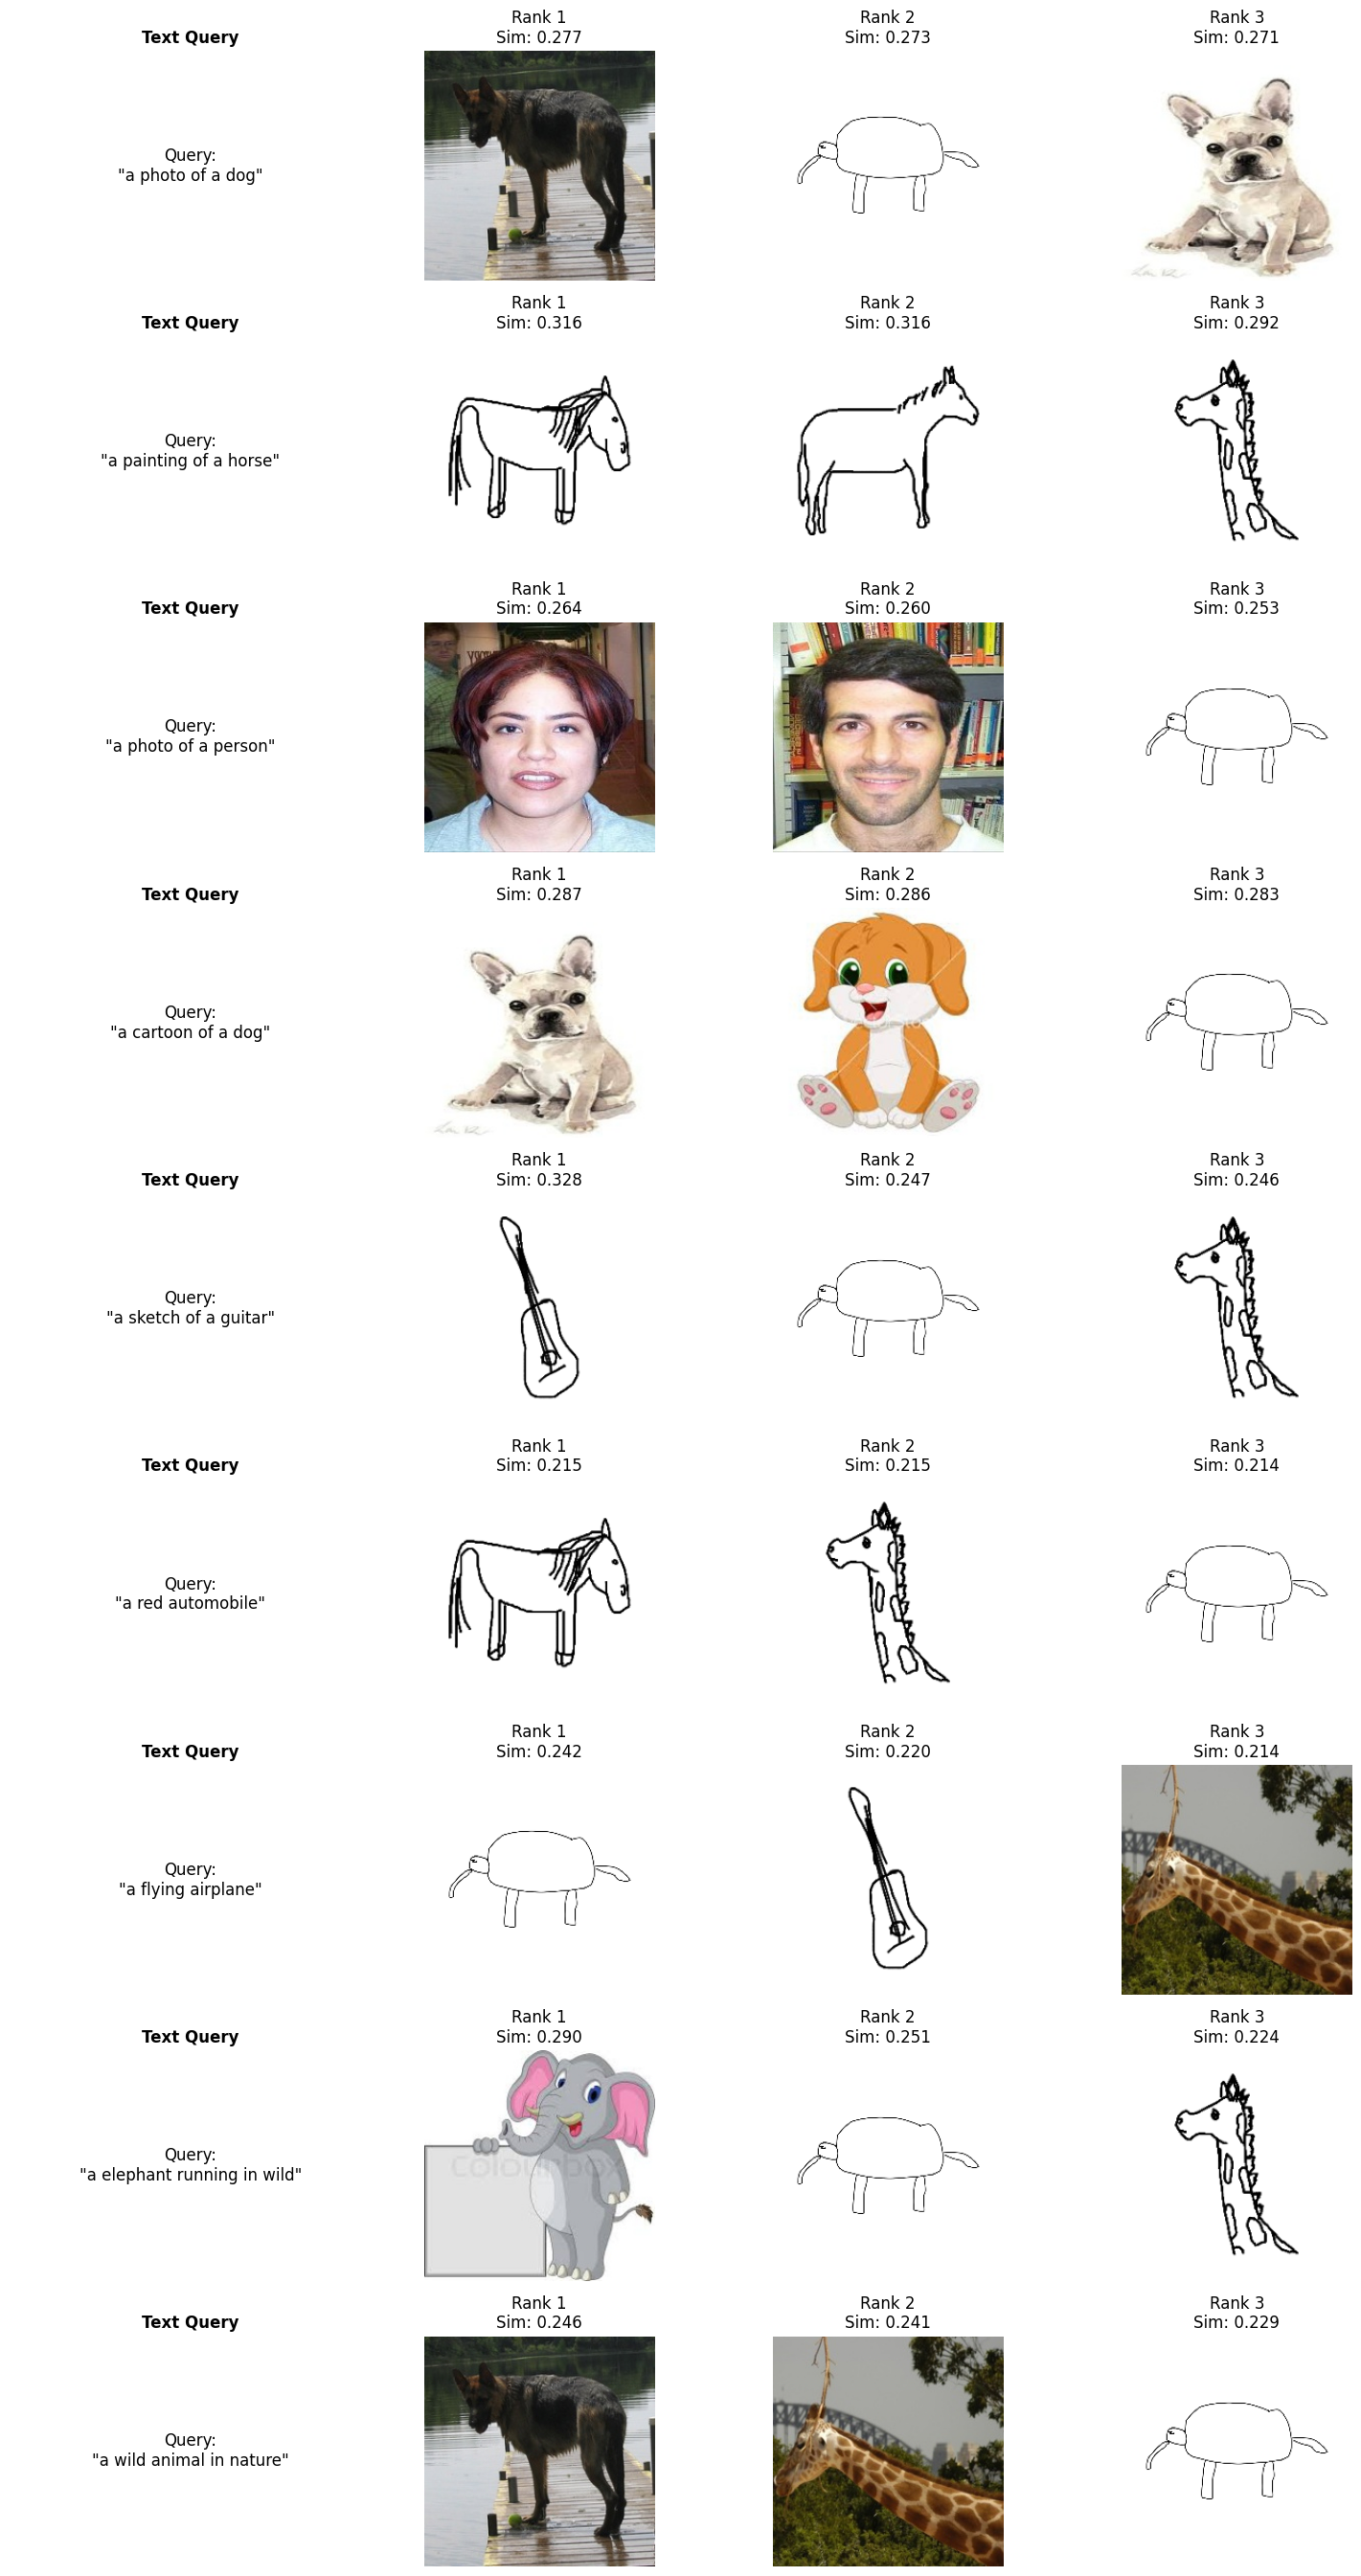

Image 0
Best matching text: 'a photo of a dog'
Similarity score: 0.277
Image 1
Best matching text: 'a photo of a person'
Similarity score: 0.264
Image 2
Best matching text: 'a painting of a horse'
Similarity score: 0.250
Image 3
Best matching text: 'a photo of a person'
Similarity score: 0.260
Image 4
Best matching text: 'a wild animal in nature'
Similarity score: 0.241


In [ ]:
#Results of Image-Text Retrieval

similarity, original_images = image_text_retrieval(model, preprocess, original_images, text_queries)
visualize_retrieval_results(similarity, original_images, text_queries)


In [ ]:
#Representation Analysis Dataset Preparation

imagevit = []
labelvit = []
domainvit =[]
namevit = []

imagern50 = []
labelrn50 = []
domain50 =[]
namern50 = []

domains = ['cifar10','photo', 'art_painting', 'cartoon', 'sketch']

def dataset(name):
  images = []
  labels = []
  domains = []
  name = []

  if name == 'vit':
    dataset = dataset_vit32
    dataset2 = pacs_datasets_vit
  else:
    dataset = dataset_rn50
    dataset2 = pacs_datasets_rn50

  cifar_samples = min(100, len(dataset))  # Take 100 from CIFAR-10
  for i in range(cifar_samples):
      image, label = dataset[i]
      images.append(image)
      labels.append(label)
      domains.append('cifar10')
      name.append(CIFAR10_CLASSES[label])

  samples_per_domain = 25
  for domain in pacs_domains:
      dataset = dataset2[domain]
      for i in range(min(samples_per_domain, len(dataset))):
          image, label = dataset[i]
          images.append(image)
          labels.append(label)
          domains.append(domain)
          name.append(PAC_CLASSES[label])

  return images, labels, domains, name

imagevit, labelvit, domainvit, namevit = dataset('vit')
imagern50, labelrn50, domain50, namern50 = dataset('rn50')


In [ ]:
def compute_embeddings_for_mixed_data(model, images, device):
    model.eval()
    embeddings = []

    with torch.no_grad():
        for image in tqdm(images, desc="Computing embeddings"):
            img_tensor = image.unsqueeze(0).to(device)
            features = model.encode_image(img_tensor)
            embeddings.append(features.cpu().numpy())

    return np.vstack(embeddings)

In [ ]:
def plot_tsne_analysis(embeddings, class_names, domains, title, model_name):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Color by Class name
    unique_classes = sorted(set(class_names))
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classes)))
    class_to_color = {cls: colors[i] for i, cls in enumerate(unique_classes)}

    for cls in unique_classes:
        indices = [i for i, c in enumerate(class_names) if c == cls]
        ax1.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                   color=class_to_color[cls], label=cls, alpha=0.7, s=30)

    ax1.set_title(f'{model_name} - Colored by Class')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    # Plot 2: Color by domain
    unique_domains = sorted(set(domains))
    domain_colors = plt.cm.Set2(np.linspace(0, 1, len(unique_domains)))
    domain_to_color = {dom: domain_colors[i] for i, dom in enumerate(unique_domains)}

    for dom in unique_domains:
        indices = [i for i, d in enumerate(domains) if d == dom]
        ax2.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                   color=domain_to_color[dom], label=dom, alpha=0.7, s=30)

    ax2.set_title(f'{model_name} - Colored by Domain')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.suptitle(f'{title}\n{model_name} Feature Space Visualization', fontsize=16)
    plt.tight_layout()
    plt.show()

Computing ViT-B/32 embeddings...


Computing embeddings: 100%|██████████| 200/200 [00:02<00:00, 92.65it/s] 


Computing RN50 embeddings...


Computing embeddings: 100%|██████████| 200/200 [00:02<00:00, 86.97it/s] 


Creating ViT-B/32 t-SNE...


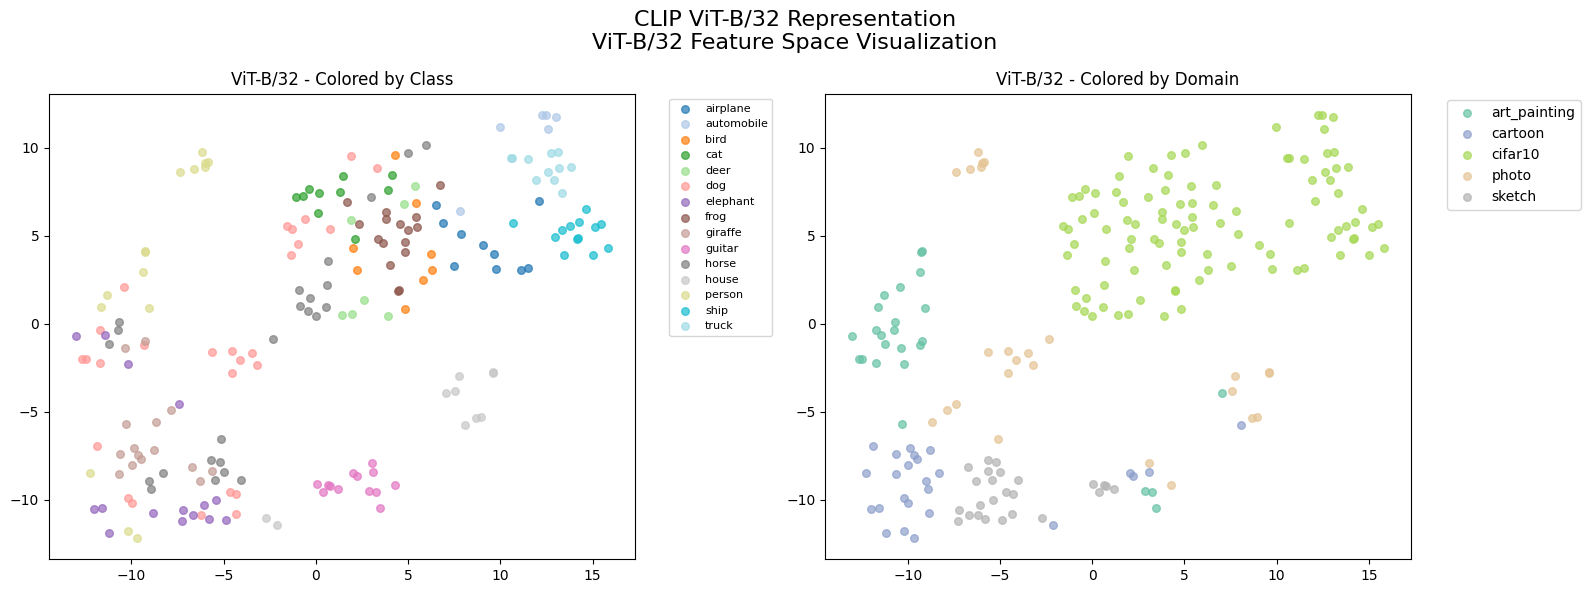

Creating RN50 t-SNE...


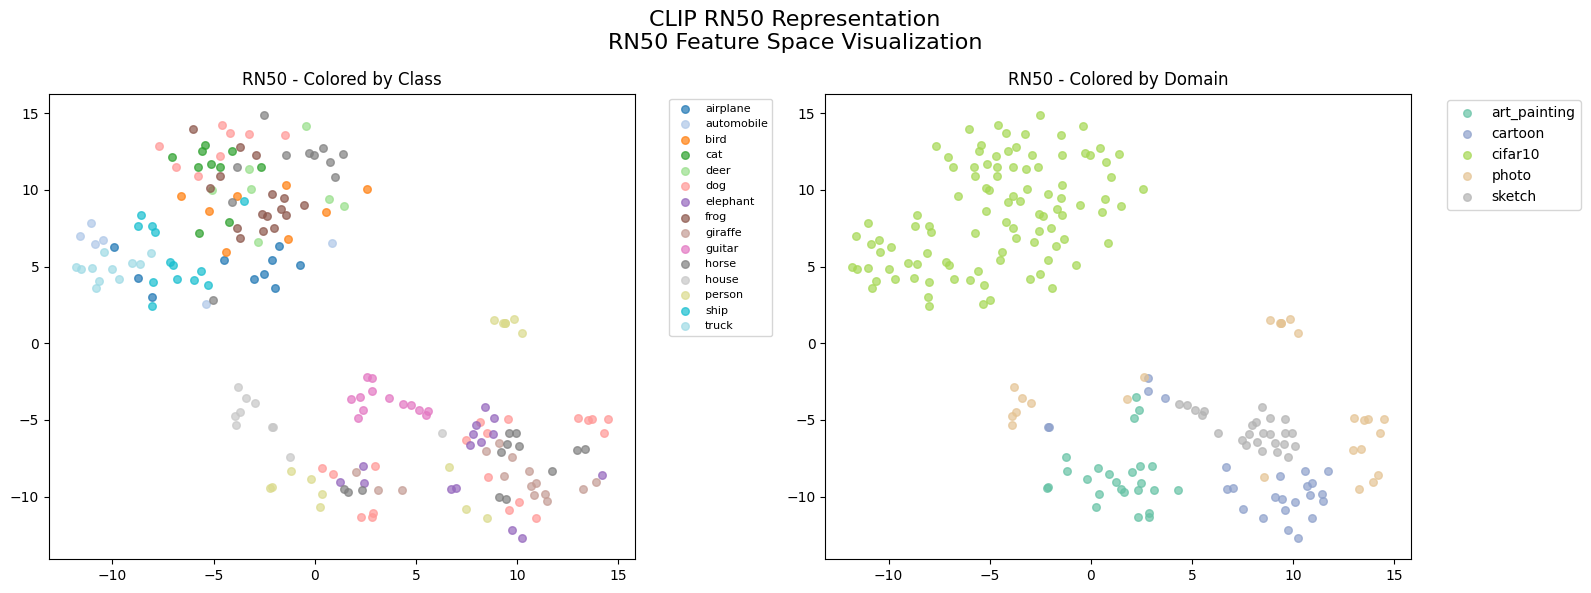

In [ ]:
#Representation Analysis Results

print("Computing ViT-B/32 embeddings...")
vit_embeddings = compute_embeddings_for_mixed_data(model, imagevit, device)

print("Computing RN50 embeddings...")
rn50_embeddings = compute_embeddings_for_mixed_data(base_model, imagern50, device)

print("Creating ViT-B/32 t-SNE...")
vit_2d = plot_tsne_analysis(vit_embeddings, namevit, domainvit,
                           "CLIP ViT-B/32 Representation", "ViT-B/32")

print("Creating RN50 t-SNE...")
rn50_2d = plot_tsne_analysis(rn50_embeddings, namern50, domain50,
                            "CLIP RN50 Representation", "RN50")

In [ ]:
# Pictures for Shape-Texture Bias Quick Test

old_cue_conflict_urls = [
    "https://raw.githubusercontent.com/rgeirhos/texture-vs-shape/master/stimuli/style-transfer-preprocessed-512/boat/boat10-cat1.png",
    "https://raw.githubusercontent.com/rgeirhos/texture-vs-shape/master/stimuli/style-transfer-preprocessed-512/bear/bear3-airplane1.png",
    "https://raw.githubusercontent.com/rgeirhos/texture-vs-shape/master/stimuli/style-transfer-preprocessed-512/dog/dog10-oven2.png",
    "https://raw.githubusercontent.com/rgeirhos/texture-vs-shape/master/stimuli/style-transfer-preprocessed-512/dog/dog9-car1.png",
    "https://raw.githubusercontent.com/rgeirhos/texture-vs-shape/master/stimuli/style-transfer-preprocessed-512/car/car1-chair3.png",
    "https://raw.githubusercontent.com/rgeirhos/texture-vs-shape/master/stimuli/style-transfer-preprocessed-512/cat/cat2-elephant1.png"
]

cue_conflict_urls = [
    "https://raw.githubusercontent.com/rgeirhos/texture-vs-shape/master/stimuli/style-transfer-preprocessed-512/bird/bird1-bicycle2.png",
    "https://raw.githubusercontent.com/rgeirhos/texture-vs-shape/master/stimuli/style-transfer-preprocessed-512/bear/bear3-airplane1.png",
    "https://raw.githubusercontent.com/rgeirhos/texture-vs-shape/master/stimuli/style-transfer-preprocessed-512/dog/dog10-oven2.png",
    "https://raw.githubusercontent.com/rgeirhos/texture-vs-shape/master/stimuli/style-transfer-preprocessed-512/bear/bear2-car2.png",
    "https://raw.githubusercontent.com/rgeirhos/texture-vs-shape/master/stimuli/style-transfer-preprocessed-512/elephant/elephant2-bottle3.png",
    "https://raw.githubusercontent.com/rgeirhos/texture-vs-shape/master/stimuli/style-transfer-preprocessed-512/car/car8-cat1.png"
]

In [ ]:
image_tests = {
    "bird1-bicycle2.png": ("a photo of a bird", "a photo of a bicycle"),
    "bear3-airplane1.png": ("a photo of a bear", "a photo of an airplane"),
    "dog10-oven2.png": ("a photo of a dog", "a photo of an oven"),
    "bear2-car2.png": ("a photo of a bear", "a photo of a car"),
    "elephant2-bottle3.png": ("a photo of an elephant", "a photo of a bottle"),
    "car8-cat1.png": ("a photo of a car", "a photo of a cat")
}

In [ ]:
def evaluateShapeTexture(model, preprocess_func, urls):
    results = {}

    for url in urls:
        try:
            response = requests.get(url)
            image = Image.open(BytesIO(response.content)).convert('RGB')
            image = image.resize((224, 224))

            img_name = url.split('/')[-1]
            shape_query, texture_query = image_tests[img_name]


            processed_img = preprocess_func(image).unsqueeze(0).to(device)


            with torch.no_grad():
                image_features = model.encode_image(processed_img)
                image_features /= image_features.norm(dim=-1, keepdim=True)


                text_tokens = clip.tokenize([shape_query, texture_query]).to(device)
                text_features = model.encode_text(text_tokens)
                text_features /= text_features.norm(dim=-1, keepdim=True)


                similarities = (image_features @ text_features.T).cpu().numpy()[0]
                shape_sim, texture_sim = similarities[0], similarities[1]


            results[img_name] = {
                'image name' : img_name,
                'shape_similarity': shape_sim,
                'texture_similarity': texture_sim,
                'stronger': 'SHAPE' if shape_sim > texture_sim else 'TEXTURE',
                'difference': shape_sim - texture_sim
            }

        except Exception as e:
            print(f"Error with {url}: {e}")
            results[img_name] = {'error': str(e)}

    return results

In [ ]:
#Shapes vs Texture

print("CLIP RN50 Results")

rn50results = evaluateShapeTexture(base_model, base_preprocess, cue_conflict_urls)
for img_name, result in rn50results.items():
    if 'error' not in result:
        print(f"{img_name}: Shape {result['shape_similarity']:.3f} vs Texture {result['texture_similarity']:.3f} → {result['stronger']}")

print("\nCLIP ViT-B/32 Results")

vitresults = evaluateShapeTexture(model, preprocess, cue_conflict_urls)
for img_name, result in vitresults.items():
    if 'error' not in result:
        print(f"{img_name}: Shape {result['shape_similarity']:.3f} vs Texture {result['texture_similarity']:.3f} → {result['stronger']}")

CLIP RN50 Results
bird1-bicycle2.png: Shape 0.140 vs Texture 0.182 → TEXTURE
bear3-airplane1.png: Shape 0.151 vs Texture 0.183 → TEXTURE
dog10-oven2.png: Shape 0.149 vs Texture 0.215 → TEXTURE
bear2-car2.png: Shape 0.116 vs Texture 0.193 → TEXTURE
elephant2-bottle3.png: Shape 0.153 vs Texture 0.181 → TEXTURE
car8-cat1.png: Shape 0.146 vs Texture 0.186 → TEXTURE

CLIP ViT-B/32 Results
bird1-bicycle2.png: Shape 0.251 vs Texture 0.236 → SHAPE
bear3-airplane1.png: Shape 0.244 vs Texture 0.231 → SHAPE
dog10-oven2.png: Shape 0.240 vs Texture 0.230 → SHAPE
bear2-car2.png: Shape 0.217 vs Texture 0.238 → TEXTURE
elephant2-bottle3.png: Shape 0.280 vs Texture 0.187 → SHAPE
car8-cat1.png: Shape 0.216 vs Texture 0.260 → TEXTURE


In [ ]:
#Perturbations Set-up

def corruption(img):
  img_arr = np.array(img)
  severity = random.randint(1, 5)

  #Gaussian Noise
  noise_levels = [8, 16, 24, 32, 40]
  noise = np.random.normal(0, noise_levels[severity-1], img_arr.shape).astype(np.uint8)
  corrupted = np.clip(img_arr + noise, 0, 255)

  #Contrast Adjustment
  contrast_factors = [0.9, 0.7, 0.5, 0.3, 0.1]
  mean = np.mean(corrupted, axis=(0, 1), keepdims=True)
  corrupted = np.clip((corrupted - mean) * contrast_factors[severity-1] + mean, 0, 255).astype(np.uint8)

  #Brightness
  brightness_adj = [10, 20, 30, 40, 50]
  corrupted = np.clip(corrupted + brightness_adj[severity-1], 0, 255).astype(np.uint8)
  corrupted_img2 = Image.fromarray(corrupted)

  #Speckle Noise
  x = np.array(corrupted_img2)
  c_values = [.06, .1, .12, .16, .2]
  c = c_values[severity-1]
  x = np.array(x) / 255.
  corrupted_3=np.clip(x + x * np.random.normal(size=x.shape, scale=c), 0, 1) * 255
  corrupted_3 = corrupted_3.astype(np.uint8)
  return Image.fromarray(corrupted_3)

In [ ]:
def compute_similarity(image_features, text_features):
    similarity_scores = (image_features @ text_features.T)
    probs = similarity_scores.softmax(dim=-1)
    predictions = similarity_scores.argmax(dim=1)
    return probs, predictions

def evaluatePerturbations(model, text_type, test_loader, preprocess_func):
    text_features = model.encode_text(clip.tokenize(text_type).to(device))
    clean_accuracies = []
    corrupted_accuracies = []
    model.eval()
    if model == base_model:
      preprocess_func = base_preprocess
    else:
      preprocess_func = preprocess
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing perturbations"):
            images = images.to(device)
            labels = labels.to(device)

            # Test clean images
            image_features = model.encode_image(images)
            probs, predictions = compute_similarity(image_features, text_features)
            clean_acc = (predictions == labels).float().mean().item()
            clean_accuracies.append(clean_acc)

            # Test corrupted images
            corrupted_images = []
            for img in images.cpu():
                img_pil = transforms.ToPILImage()(img)
                corrupted_img = corruption(img_pil)
                corrupted_tensor = preprocess_func(corrupted_img).to(device)
                corrupted_images.append(corrupted_tensor)

            if len(corrupted_images) == 0:
                print("⚠️ Warning: No corrupted images generated")
                corrupted_acc = 0.0
            else:
                corrupted_batch = torch.stack(corrupted_images)
                corrupted_features = model.encode_image(corrupted_batch)
                corrupted_probs, corrupted_predictions = compute_similarity(corrupted_features, text_features)
                corrupted_acc = (corrupted_predictions == labels).float().mean().item()

            corrupted_accuracies.append(corrupted_acc)

    final_clean_accuracy = np.mean(clean_accuracies)
    final_corrupted_accuracy = np.mean(corrupted_accuracies)
    accuracy_drop = final_clean_accuracy - final_corrupted_accuracy
    robustness_ratio = final_corrupted_accuracy / final_clean_accuracy if final_clean_accuracy > 0 else 0

    return {
        'clean_accuracy': final_clean_accuracy,
        'corrupted_accuracy': final_corrupted_accuracy,
        'accuracy_drop': accuracy_drop,
        'robustness_ratio': robustness_ratio,
        'samples_tested': len(clean_accuracies) * BATCH_SIZE
    }

In [ ]:
#Robustness results

vit_results= evaluatePerturbations(model, prompt_CIFAR10, test_vit32loader, preprocess)
print(f"ViT-B/32 Results: {vit_results}")

rn50_results = evaluatePerturbations(base_model, prompt_CIFAR10, test_rn50loader, base_preprocess)
print(f"RN50 Results: {rn50_results}")

# Compare robustness
print(f"ViT Robustness Ratio: {vit_results['robustness_ratio']:.3f}")
print(f"RN50 Robustness Ratio: {rn50_results['robustness_ratio']:.3f}")

Testing perturbations: 100%|██████████| 313/313 [03:09<00:00,  1.65it/s]


ViT-B/32 Results: {'clean_accuracy': np.float64(0.7998202875399361), 'corrupted_accuracy': np.float64(0.24690495207667731), 'accuracy_drop': np.float64(0.5529153354632588), 'robustness_ratio': np.float64(0.3087005367619523), 'samples_tested': 10016}


Testing perturbations: 100%|██████████| 313/313 [03:18<00:00,  1.58it/s]

RN50 Results: {'clean_accuracy': np.float64(0.6340854632587859), 'corrupted_accuracy': np.float64(0.15375399361022365), 'accuracy_drop': np.float64(0.4803314696485622), 'robustness_ratio': np.float64(0.24248149897653917), 'samples_tested': 10016}
ViT Robustness Ratio: 0.309
RN50 Robustness Ratio: 0.242
